# Projet Machine Learning - Image 
CERCELET Matthias et RODRIGUEZ Franck

## Sujet : Analyse d'ECG à 12 dérivations

In [1]:
# Tous les packages nécessaire au bon lancement du reseau neuronal du github.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

from keras.models import load_model
from tensorflow.keras.optimizers import Adam 

# Tous les packages pour les différents clissifieursque nous allons utilisés plus bas.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

Pour ce projet de Machine learning, nous allons vouloir prédire si un patient est atteint d'une maladie ou non à l'aide d'électrocardiogrammes. 
Ceux-ci sont fait à partir de 12 dérivations les voici : 
- Frontales : I, II, III, aVR, aVL, aVF
- Précordiales : V1, V2, V3, V4, V5, V6
- Dérivations mesurées : I, II, III, V1, V2, V3, V4, V5, V6
- Dérivations calculées : aVR, aVL, aVF

À l'aide de ces électrocardiogrammes, des médecins plus ou moins ont pu diagnostiquer ou non des anomalies cardiaques. Nous en reviendrons plus en détails après le code ci-dessous.

In [2]:
df_goldStandard = pd.read_csv(os.path.expanduser('~/Desktop/ML/data/annotations/gold_standard.csv'))
print("La taille de l'échantillon est :", df_goldStandard.shape)

df_goldStandard['nb_abnormality'] =  df_goldStandard.sum(axis=1)

df_goldStandard.head(20).T

La taille de l'échantillon est : (827, 6)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1dAVb,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
RBBB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LBBB,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
SB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ST,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nb_abnormality,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,2,0


Les nombres sur la première ligne représente les patients, il y en a au total 827.
La première colone à gauche représente les anormalitées qu'on pu percevoir les différents médecins ou spécialistes de santé suivant les électrocardiogrammes. 

Lorsque sur la ligne l'on à un $0$ à l'endroit d'un patient, cela signifie que ce patient ci n'a pas cette anormalitée, ou du moins que le spécialiste ne l'a pas décelé.
Au contraire lorsque l'on à un $1$, cela signifie que le spécialiste à décelé cette anomalie.

Si l'on prend l'anomalie $\textbf{1dAVb}$, on peut voir que les patients $12$,$15$ et $18$ on cet anomalie d'après l'analyse d'un troisième médecin après le passage de ses deux premiers confrères cardiologues.

Pour avoir de meilleurs résultats, l'équipe de chercheurs s'est appuyé sur différents bilans de plusieurs spécialistes. Nous en avons 7 différents :
- Le cardiologue 1
- Le cardiologue 2
- Un troisième cardiologue donne son avis dans le cas ou les 2 premiers ne sont pas d'accord et si ils le sont le resultats est appelé $\textbf{gold_standard}$.
- Le résultat obtenu à l'aide d'un réseau de neurone profond qui a pour but de maximiser le $\textit{F1-score}$.
- Résultats de deux étudiants en 4ème année de cardiologie (chacun leur partie)
- Résultats de deux étudiants en 3ème année d'urgence (chacun leur partie)
- Résultats de deux étudiants en 5ème année de médecine (chacun leur partie)

Voici une partie de ces résultats pour chaque spécialiste :

In [3]:
#cardiologue 1
df_cardio1 = pd.read_csv(os.path.expanduser('~/Desktop/ML/data/annotations/cardiologist1.csv'))
print("La taille de l'échantillon est :", df_cardio1.shape)
df_cardio1['nb_abnormality'] =  df_cardio1.sum(axis=1)
df_cardio1.head(20).T

La taille de l'échantillon est : (827, 6)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1dAVb,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
RBBB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LBBB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
SB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ST,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nb_abnormality,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,2,0


In [4]:
# cardiologue 2
df_cardio2 = pd.read_csv(os.path.expanduser('~/Desktop/ML/data/annotations/cardiologist2.csv'))
print("La taille de l'échantillon est :", df_cardio2.shape)
df_cardio2['nb_abnormality'] =  df_cardio2.sum(axis=1)
df_cardio2.head(20).T

La taille de l'échantillon est : (827, 6)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1dAVb,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
RBBB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LBBB,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
SB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ST,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nb_abnormality,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,2,0


In [5]:
# Étudiants en cardiologie
df_cardiores = pd.read_csv(os.path.expanduser('~/Desktop/ML/data/annotations/cardiology_residents.csv'))
print("La taille de l'échantillon est :", df_cardiores.shape)
df_cardiores['nb_abnormality'] =  df_cardiores.sum(axis=1)
df_cardiores.head(20).T

La taille de l'échantillon est : (827, 6)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1dAVb,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
RBBB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LBBB,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
SB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ST,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nb_abnormality,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0


In [6]:
# Étudiants aux urgences
df_cardioemer = pd.read_csv(os.path.expanduser('~/Desktop/ML/data/annotations/emergency_residents.csv'))
print("La taille de l'échantillon est :", df_cardioemer.shape)
df_cardioemer['nb_abnormality'] =  df_cardioemer.sum(axis=1)
df_cardioemer.head(20).T

La taille de l'échantillon est : (827, 6)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1dAVb,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
RBBB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LBBB,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
SB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ST,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nb_abnormality,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,2,0


In [7]:
# Étudiants en médecine
df_cardiomed = pd.read_csv(os.path.expanduser('~/Desktop/ML/data/annotations/medical_students.csv'))
print("La taille de l'échantillon est :", df_cardiomed.shape)
df_cardiomed['nb_abnormality'] =  df_cardiomed.sum(axis=1)
df_cardiomed.head(20).T

La taille de l'échantillon est : (827, 6)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1dAVb,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
RBBB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LBBB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
SB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ST,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nb_abnormality,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,2,0


In [8]:
# Réseau neuronal
df_cardiodnn = pd.read_csv(os.path.expanduser('~/Desktop/ML/data/annotations/dnn.csv'))
print("La taille de l'échantillon est :", df_cardiodnn.shape)
df_cardiodnn['nb_abnormality'] =  df_cardiodnn.sum(axis=1)
df_cardiodnn.head(20).T

La taille de l'échantillon est : (827, 7)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1dAVb,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
RBBB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LBBB,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
SB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ST,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nb_abnormality,0,2,2,3,4,5,6,7,8,9,10,11,13,13,14,17,16,17,20,19


# TRAIN.PY

Le code ci-dessous va nous permettre d'entrainer notre model. Comme vous le verrez ci-dessous, en dépit de la puissance de l'ordinateur sur lequel nous effectuons ce code, le nombre de passage de ce dataset dans notre modèle, le nombre n'est pas très élevé. 
Sur les $70$ possible, seulement $18$ ont été effectué, ce qui nous montre que notre modèle manque de précision et que nous pouvons obtenir de meilleur résultats avec une plus grande puissance.

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from model import get_model
import argparse
from datasets import ECGSequence

if __name__ == "__main__":
    # Get data and train
    parser = argparse.ArgumentParser(description='Train neural network.')
    parser.add_argument('path_to_hdf5', type=str,
                        help='path to hdf5 file containing tracings')
    parser.add_argument('path_to_csv', type=str,
                        help='path to csv file containing annotations')
    parser.add_argument('--val_split', type=float, default=0.02,
                        help='number between 0 and 1 determining how much of'
                             ' the data is to be used for validation. The remaining '
                             'is used for validation. Default: 0.02')
    parser.add_argument('--dataset_name', type=str, default='tracings',
                        help='name of the hdf5 dataset containing tracings')
    
    #### On a ajouté ici le chemin entre le path_to_hdf5 et path_to_csv ####
    args = parser.parse_args(['data/ecg_tracings.hdf5','data/annotations/gold_standard.csv'])
    
    
    # Optimization settings
    loss = 'binary_crossentropy'
    lr = 0.001
    batch_size = 64
    opt = Adam(lr)
    callbacks = [ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=7,
                                   min_lr=lr / 100),
                 EarlyStopping(patience=9,  # Patience should be larger than the one in ReduceLROnPlateau
                               min_delta=0.00001)]

    train_seq, valid_seq = ECGSequence.get_train_and_val(
        args.path_to_hdf5, args.dataset_name, args.path_to_csv, batch_size, args.val_split)

    # If you are continuing an interrupted section, uncomment line bellow:
    #   model = keras.models.load_model(PATH_TO_PREV_MODEL, compile=False)
    model = get_model(train_seq.n_classes)
    model.compile(loss=loss, optimizer=opt)
    
    # Create log
    callbacks += [TensorBoard(log_dir='./logs', write_graph=False),
                  CSVLogger('training.log', append=False)]  # Change append to true if continuing training
    
    # Save the BEST and LAST model
    callbacks += [ModelCheckpoint('./backup_model_last.hdf5'),
                  ModelCheckpoint('./backup_model_best.hdf5', save_best_only=True)]
    
    # Train neural network
    history = model.fit(train_seq,
                        epochs=70,
                        initial_epoch=0,  # If you are continuing a interrupted section change here
                        callbacks=callbacks,
                        validation_data=valid_seq,
                        verbose=1)
    # Save final result
    model.save("./final_model.hdf5")

2021-11-03 15:08:22.014655: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-03 15:08:22.014677: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-03 15:08:22.014704: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/70
 1/13 [=>............................] - ETA: 2:38 - loss: 0.8979

2021-11-03 15:08:35.338694: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-03 15:08:35.338712: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/13 [===>..........................] - ETA: 1:37 - loss: 0.5975

2021-11-03 15:08:44.223036: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-03 15:08:44.245816: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-03 15:08:44.269069: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_11_03_15_08_44

2021-11-03 15:08:44.289390: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_11_03_15_08_44/MBPdeMatthias2.trace.json.gz
2021-11-03 15:08:44.316794: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_11_03_15_08_44

2021-11-03 15:08:44.317220: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_11_03_15_08_44/MBPdeMatthias2.memory_profile.json.gz
2021-11-03 15:08:

13/13 [==============================] - 145s 11s/step - loss: 0.2529 - val_loss: 1.0684


/Users/MatthiasCercelet/opt/anaconda3/envs/tfenv/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/70
13/13 [==============================] - 120s 9s/step - loss: 0.1437 - val_loss: 1.1946
Epoch 3/70
13/13 [==============================] - 117s 9s/step - loss: 0.1113 - val_loss: 0.3086
Epoch 4/70
13/13 [==============================] - 116s 9s/step - loss: 0.1036 - val_loss: 0.1270
Epoch 5/70
13/13 [==============================] - 116s 9s/step - loss: 0.0904 - val_loss: 0.0860
Epoch 6/70
13/13 [==============================] - 114s 9s/step - loss: 0.0785 - val_loss: 0.1054
Epoch 7/70
13/13 [==============================] - 114s 9s/step - loss: 0.0646 - val_loss: 0.0730
Epoch 8/70
13/13 [==============================] - 113s 9s/step - loss: 0.0494 - val_loss: 0.0763
Epoch 9/70
13/13 [==============================] - 118s 9s/step - loss: 0.0439 - val_loss: 0.0664
Epoch 10/70
13/13 [==============================] - 114s 9s/step - loss: 0.0367 - val_loss: 0.1206
Epoch 11/70
13/13 [==============================] - 122s 9s/step - loss: 0.0264 - val_loss: 0.0986
Epoch 12

# PREDICT.PY

Dans la cellule ci-dessous, nous allons prédire à l'aide d'un model. Nous aurions pu utilisé le model créer ci dessus, or celui-ci n'est pas optimal. Heureusement, le groupe de chercheurs scientifiques nous ont laissé un un model optimisé.

In [9]:
import numpy as np
import warnings
import argparse
warnings.filterwarnings("ignore")
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from datasets import ECGSequence


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Get performance on test set from hdf5')
    parser.add_argument('path_to_hdf5', type=str,
                        help='path to hdf5 file containing tracings')
    parser.add_argument('path_to_model',  # or model_date_order.hdf5
                        help='file containing training model.')
    parser.add_argument('--dataset_name', type=str, default='tracings',
                        help='name of the hdf5 dataset containing tracings')
    parser.add_argument('--output_file', default="./dnn_output.npy",  # or predictions_date_order.csv
                        help='output csv file.')
    parser.add_argument('-bs', type=int, default=32,
                        help='Batch size.')

    #### Nous avons rajouté dans la ligne ci-dessous les fichiers ####
    args, unk = parser.parse_known_args(['data/ecg_tracings.hdf5','model/model.hdf5'])
    if unk:
        warnings.warn("Unknown arguments:" + str(unk) + ".")

    # Import data
    seq = ECGSequence(args.path_to_hdf5, args.dataset_name, batch_size=args.bs)
    # Import model
    model = load_model(args.path_to_model, compile=False)
    model.compile(loss='binary_crossentropy', optimizer=Adam())
    y_score = model.predict(seq,  verbose=1)

    # Generate dataframe
    np.save(args.output_file, y_score)

    print("Output predictions saved")

2021-11-08 18:13:00.893486: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-08 18:13:01.840020: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


26/26 [==============================] - 31s 1s/step
Output predictions saved


# Generate figures and tables.py

Micro average precision
[0.94566453 0.94992158 0.95002866 0.950871   0.95182224 0.95380942
 0.95557086 0.95785818 0.95960438 0.96081937]
                                           1dAVb      RBBB      LBBB  \
DNN vs Cert. cardiol. 1                 0.757884  0.928350  0.964266   
DNN vs Certif. cardiol. 2               0.852163  0.941924  1.000000   
Cert. cardiol. 1 vs Certif. cardiol. 2  0.741285  0.954629  0.964266   

                                              SB        AF        ST  
DNN vs Cert. cardiol. 1                 0.769995  0.696328  0.846727  
DNN vs Certif. cardiol. 2               0.769995  0.746423  0.883848  
Cert. cardiol. 1 vs Certif. cardiol. 2  0.843697  0.830948  0.902492  
normal_order
date_order
individual_patients
base_model


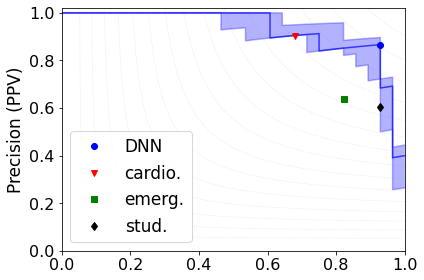

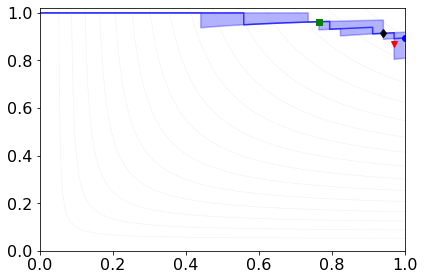

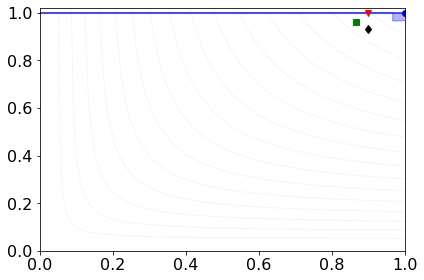

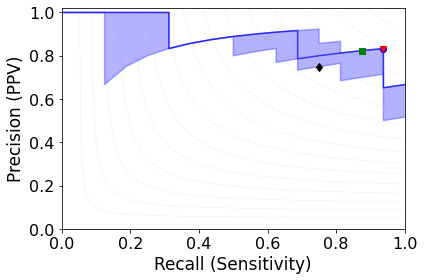

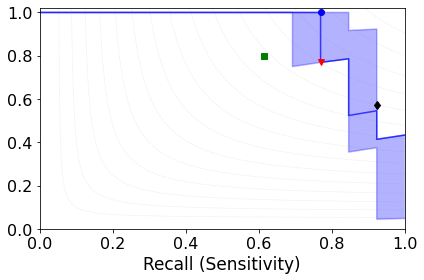

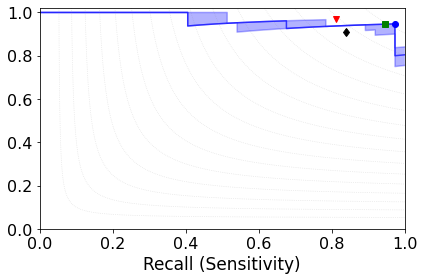

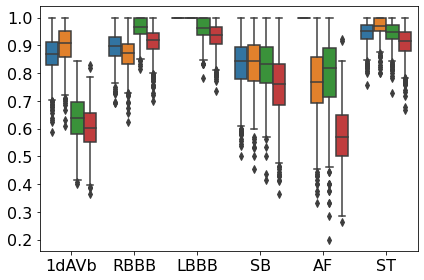

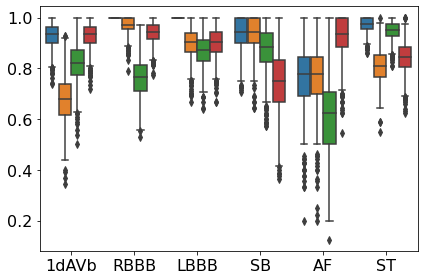

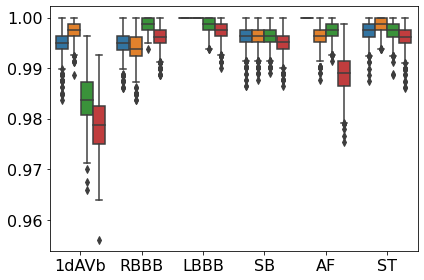

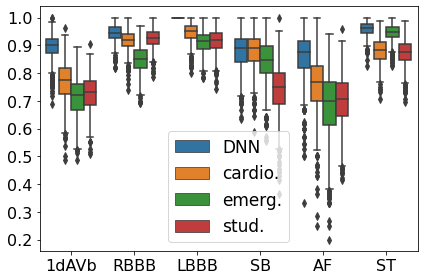

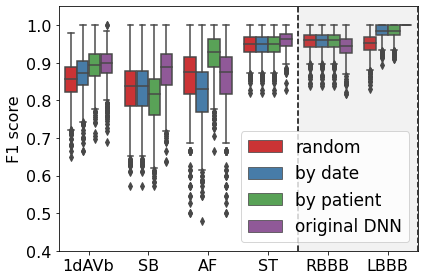

In [10]:
# %% Import packages
import pandas as pd
import numpy as np
from sklearn.metrics import (confusion_matrix,
                             precision_score, recall_score, f1_score,
                             precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from scipy.stats.distributions import chi2
from itertools import combinations


# %% Auxiliar functions
def get_scores(y_true, y_pred, score_fun):
    nclasses = np.shape(y_true)[1]
    scores = []
    for name, fun in score_fun.items():
        scores += [[fun(y_true[:, k], y_pred[:, k]) for k in range(nclasses)]]
    return np.array(scores).T


def specificity_score(y_true, y_pred):
    m = confusion_matrix(y_true, y_pred, labels=[0, 1])
    spc = m[0, 0] * 1.0 / (m[0, 0] + m[0, 1])
    return spc


def get_optimal_precision_recall(y_true, y_score):
    """Find precision and recall values that maximize f1 score."""
    n = np.shape(y_true)[1]
    opt_precision = []
    opt_recall = []
    opt_threshold = []
    for k in range(n):
        # Get precision-recall curve
        precision, recall, threshold = precision_recall_curve(y_true[:, k], y_score[:, k])
        # Compute f1 score for each point (use nan_to_num to avoid nans messing up the results)
        f1_score = np.nan_to_num(2 * precision * recall / (precision + recall))
        # Select threshold that maximize f1 score
        index = np.argmax(f1_score)
        opt_precision.append(precision[index])
        opt_recall.append(recall[index])
        t = threshold[index-1] if index != 0 else threshold[0]-1e-10
        opt_threshold.append(t)
    return np.array(opt_precision), np.array(opt_recall), np.array(opt_threshold)

def affer_results(y_true, y_pred):
    """Return true positives, false positives, true negatives, false negatives.
    Parameters
    ----------
    y_true : ndarray
        True value
    y_pred : ndarray
        Predicted value
    Returns
    -------
    tn, tp, fn, fp: ndarray
        Boolean matrices containing true negatives, true positives, false negatives and false positives.
    cm : ndarray
        Matrix containing: 0 - true negative, 1 - true positive,
        2 - false negative, and 3 - false positive.
    """

    # True negative
    tn = (y_true == y_pred) & (y_pred == 0)
    # True positive
    tp = (y_true == y_pred) & (y_pred == 1)
    # False positive
    fp = (y_true != y_pred) & (y_pred == 1)
    # False negative
    fn = (y_true != y_pred) & (y_pred == 0)

    # Generate matrix of "tp, fp, tn, fn"
    m, n = np.shape(y_true)
    cm = np.zeros((m, n), dtype=int)
    cm[tn] = 0
    cm[tp] = 1
    cm[fn] = 2
    cm[fp] = 3
    return tn, tp, fn, fp, cm


# %% Constants
score_fun = {'Precision': precision_score,
             'Recall': recall_score, 'Specificity': specificity_score,
             'F1 score': f1_score}
diagnosis = ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST']
nclasses = len(diagnosis)
predictor_names = ['DNN', 'cardio.', 'emerg.', 'stud.']

# %% Read datasets
# Get two annotators
y_cardiologist1 = pd.read_csv('./data/annotations/cardiologist1.csv').values
y_cardiologist2 = pd.read_csv('./data/annotations/cardiologist2.csv').values
# Get true values
y_true = pd.read_csv('./data/annotations/gold_standard.csv').values
# Get residents and students performance
y_cardio = pd.read_csv('./data/annotations/cardiology_residents.csv').values
y_emerg = pd.read_csv('./data/annotations/emergency_residents.csv').values
y_student = pd.read_csv('./data/annotations/medical_students.csv').values
# get y_score for different models
y_score_list = [np.load('./dnn_predicts/other_seeds/model_' + str(i+1) + '.npy') for i in range(10)]


# %% Get average model model
# Get micro average precision
micro_avg_precision = [average_precision_score(y_true[:, :6], y_score[:, :6], average='micro')
                           for y_score in y_score_list]
# get ordered index
index = np.argsort(micro_avg_precision)
print('Micro average precision')
print(np.array(micro_avg_precision)[index])
# get 6th best model (immediatly above median) out 10 different models
k_dnn_best = index[5]
y_score_best = y_score_list[k_dnn_best]
# Get threshold that yield the best precision recall using "get_optimal_precision_recall" on validation set
#   (we rounded it up to three decimal cases to make it easier to read...)
threshold = np.array([0.124, 0.07, 0.05, 0.278, 0.390, 0.174])
mask = y_score_best > threshold
# Get neural network prediction
# This data was also saved in './data/annotations/dnn.csv'
y_neuralnet = np.zeros_like(y_score_best)
y_neuralnet[mask] = 1
y_neuralnet[mask] = 1


# %% Generate table with scores for the average model (Table 2)
scores_list = []
for y_pred in [y_neuralnet, y_cardio, y_emerg, y_student]:
    # Compute scores
    scores = get_scores(y_true, y_pred, score_fun)
    # Put them into a data frame
    scores_df = pd.DataFrame(scores, index=diagnosis, columns=score_fun.keys())
    # Append
    scores_list.append(scores_df)
# Concatenate dataframes
scores_all_df = pd.concat(scores_list, axis=1, keys=['DNN', 'cardio.', 'emerg.', 'stud.'])
# Change multiindex levels
scores_all_df = scores_all_df.swaplevel(0, 1, axis=1)
scores_all_df = scores_all_df.reindex(level=0, columns=score_fun.keys())
# Save results
scores_all_df.to_excel("./outputs/tables/scores.xlsx", float_format='%.3f')
scores_all_df.to_csv("./outputs/tables/scores.csv", float_format='%.3f')


# %% Plot precision recall curves (Figure 2)
for k, name in enumerate(diagnosis):
    precision_list = []
    recall_list = []
    threshold_list = []
    average_precision_list = []
    fig, ax = plt.subplots()
    lw = 2
    t = ['bo', 'rv', 'gs', 'kd']
    for j, y_score in enumerate(y_score_list):
        # Get precision-recall curve
        precision, recall, threshold = precision_recall_curve(y_true[:, k], y_score[:, k])
        recall[np.isnan(recall)] = 0  # change nans to 0
        precision[np.isnan(precision)] = 0  # change nans to 0
        # Plot if is the choosen option
        if j == k_dnn_best:
            ax.plot(recall, precision, color='blue', alpha=0.7)
        # Compute average precision
        average_precision = average_precision_score(y_true[:, k], y_score[:, k])
        precision_list += [precision]
        recall_list += [recall]
        average_precision_list += [average_precision]
        threshold_list += [threshold]
    # Plot shaded region containing maximum and minimun from other executions
    recall_all = np.concatenate(recall_list)
    recall_all = np.sort(recall_all)  # sort
    recall_all = np.unique(recall_all)  # remove repeated entries
    recall_vec = []
    precision_min = []
    precision_max = []
    for r in recall_all:
        p_max = [max(precision[recall == r]) for recall, precision in zip(recall_list, precision_list)]
        p_min = [min(precision[recall == r]) for recall, precision in zip(recall_list, precision_list)]
        recall_vec += [r, r]
        precision_min += [min(p_max), min(p_min)]
        precision_max += [max(p_max), max(p_min)]
    ax.plot(recall_vec, precision_min, color='blue', alpha=0.3)
    ax.plot(recall_vec, precision_max, color='blue', alpha=0.3)
    ax.fill_between(recall_vec, precision_min, precision_max,
                    facecolor="blue", alpha=0.3)
    # Plot iso-f1 curves
    f_scores = np.linspace(0.1, 0.95, num=15)
    for f_score in f_scores:
        x = np.linspace(0.0000001, 1, 1000)
        y = f_score * x / (2 * x - f_score)
        ax.plot(x[y >= 0], y[y >= 0], color='gray', ls=':', lw=0.7, alpha=0.25)
    # Plot values in
    for npred in range(4):
        ax.plot(scores_list[npred]['Recall'][k], scores_list[npred]['Precision'][k],
                t[npred], label=predictor_names[npred])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.02])
    if k in [3, 4, 5]:
        ax.set_xlabel('Recall (Sensitivity)', fontsize=17)
    if k in [0, 3]:
        ax.set_ylabel('Precision (PPV)', fontsize=17)
    # plt.title('Precision-Recall curve (' + name + ')')
    if k == 0:
        plt.legend(loc="lower left", fontsize=17)
    else:
        ax.legend().remove()
    plt.tight_layout()
    plt.savefig('./outputs/figures/precision_recall_{0}.pdf'.format(name))

# %% Confusion matrices (Supplementary Table 1)

M = [[confusion_matrix(y_true[:, k], y_pred[:, k], labels=[0, 1])
      for k in range(nclasses)] for y_pred in [y_neuralnet, y_cardio, y_emerg, y_student]]

M_xarray = xr.DataArray(np.array(M),
                        dims=['predictor', 'diagnosis', 'true label', 'predicted label'],
                        coords={'predictor': ['DNN', 'cardio.', 'emerg.', 'stud.'],
                                'diagnosis': diagnosis,
                                'true label': ['not present', 'present'],
                                'predicted label': ['not present', 'present']})
confusion_matrices = M_xarray.to_dataframe('n')
confusion_matrices = confusion_matrices.reorder_levels([1, 2, 3, 0], axis=0)
confusion_matrices = confusion_matrices.unstack()
confusion_matrices = confusion_matrices.unstack()
confusion_matrices = confusion_matrices['n']
confusion_matrices.to_excel("./outputs/tables/confusion matrices.xlsx", float_format='%.3f')
confusion_matrices.to_csv("./outputs/tables/confusion matrices.csv", float_format='%.3f')


#%% Compute scores and bootstraped version of these scores

bootstrap_nsamples = 1000
percentiles = [2.5, 97.5]
scores_resampled_list = []
scores_percentiles_list = []
for y_pred in [y_neuralnet, y_cardio, y_emerg, y_student]:
    # Compute bootstraped samples
    np.random.seed(123)  # NEVER change this =P
    n, _ = np.shape(y_true)
    samples = np.random.randint(n, size=n * bootstrap_nsamples)
    # Get samples
    y_true_resampled = np.reshape(y_true[samples, :], (bootstrap_nsamples, n, nclasses))
    y_doctors_resampled = np.reshape(y_pred[samples, :], (bootstrap_nsamples, n, nclasses))
    # Apply functions
    scores_resampled = np.array([get_scores(y_true_resampled[i, :, :], y_doctors_resampled[i, :, :], score_fun)
                                 for i in range(bootstrap_nsamples)])
    # Sort scores
    scores_resampled.sort(axis=0)
    # Append
    scores_resampled_list.append(scores_resampled)

    # Compute percentiles index
    i = [int(p / 100.0 * bootstrap_nsamples) for p in percentiles]
    # Get percentiles
    scores_percentiles = scores_resampled[i, :, :]
    # Convert percentiles to a dataframe
    scores_percentiles_df = pd.concat([pd.DataFrame(x, index=diagnosis, columns=score_fun.keys())
                                       for x in scores_percentiles], keys=['p1', 'p2'], axis=1)
    # Change multiindex levels
    scores_percentiles_df = scores_percentiles_df.swaplevel(0, 1, axis=1)
    scores_percentiles_df = scores_percentiles_df.reindex(level=0, columns=score_fun.keys())
    # Append
    scores_percentiles_list.append(scores_percentiles_df)
# Concatenate dataframes
scores_percentiles_all_df = pd.concat(scores_percentiles_list, axis=1, keys=predictor_names)
# Change multiindex levels
scores_percentiles_all_df = scores_percentiles_all_df.reorder_levels([1, 0, 2], axis=1)
scores_percentiles_all_df = scores_percentiles_all_df.reindex(level=0, columns=score_fun.keys())


#%% Print box plot (Supplementary Figure 1)
# Convert to xarray
scores_resampled_xr = xr.DataArray(np.array(scores_resampled_list),
                                   dims=['predictor', 'n', 'diagnosis', 'score_fun'],
                                   coords={
                                    'predictor': predictor_names,
                                    'n': range(bootstrap_nsamples),
                                    'diagnosis': ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST'],
                                    'score_fun': list(score_fun.keys())})
# Remove everything except f1_score
for sf in score_fun:
    fig, ax = plt.subplots()
    f1_score_resampled_xr = scores_resampled_xr.sel(score_fun=sf)
    # Convert to dataframe
    f1_score_resampled_df = f1_score_resampled_xr.to_dataframe(name=sf).reset_index(level=[0, 1, 2])
    # Plot seaborn
    ax = sns.boxplot(x="diagnosis", y=sf, hue="predictor", data=f1_score_resampled_df)
    # Save results
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("")
    plt.ylabel("", fontsize=16)
    if sf == "F1 score":
        plt.legend(fontsize=17)
    else:
        ax.legend().remove()
    plt.tight_layout()
    plt.savefig('./outputs/figures/boxplot_bootstrap_{}.pdf'.format(sf))


scores_resampled_xr.to_dataframe(name='score').to_csv('./outputs/figures/boxplot_bootstrap_data.txt')

#%% McNemar test  (Supplementary Table 3)
# Get correct and wrong predictions for each of them (cm >= 2 correspond to wrong predictions)
wrong_predictions = np.array([affer_results(y_true, y_pred)[4] >= 2
                              for y_pred in [y_neuralnet, y_cardio, y_emerg, y_student]])

# Compute McNemar score
names = ["DNN", "cardio.", "emerg.", "stud."]
mcnemar_name = []
mcnemar_score = np.empty((6, 6))
k = 0
for i in range(4):
    for j in range(i+1, 4):
        a_not_b = np.sum(wrong_predictions[i, :, :] & ~wrong_predictions[j, :, :], axis=0)
        b_not_a = np.sum(~wrong_predictions[i, :, :] & wrong_predictions[j, :, :], axis=0)
        # An alterantive to the standard McNemar test is to include a
        # continuity correction term, resulting in:
        # mcnemar_corr_score = np.square(np.abs(a_not_b - b_not_a) - 1) / (a_not_b + b_not_a)
        # I tested both and came the conclusion, that we cannot reject the null hypotesis
        # for neither. The standard test however provide results that are easier to visualize.
        mcnemar_score[k, :] = np.square(a_not_b - b_not_a) / (a_not_b + b_not_a)
        k += 1
        mcnemar_name += [names[i] + " vs " + names[j]]

mcnemar = pd.DataFrame(1-chi2.cdf(mcnemar_score, 1), index=mcnemar_name, columns=diagnosis) # p-value

# Save results
mcnemar.to_excel("./outputs/tables/mcnemar.xlsx", float_format='%.3f')
mcnemar.to_csv("./outputs/tables/mcnemar.csv", float_format='%.3f')

# %% Kappa score classifiers (Supplementary Table 2(a))

names = ["DNN", "cardio.", "emerg.", "stud."]
predictors = [y_neuralnet, y_cardio, y_emerg, y_student]
kappa_name = []
kappa_score = np.empty((6, 6))
k = 0
for i in range(4):
    for j in range(i+1, 4):
        y_pred_1 = predictors[i]
        y_pred_2 = predictors[j]
        # Get "confusion matrix"
        negative_negative, positive_positive, positive_negative, negative_positive, _ = \
            affer_results(y_pred_1, y_pred_2)
        p_p = positive_positive.sum(axis=0)
        p_n = positive_negative.sum(axis=0)
        n_p = negative_positive.sum(axis=0)
        n_n = negative_negative.sum(axis=0)
        total_sum = p_p + p_n + n_p + n_n
        # Relative agreement
        r_agree = (p_p + n_n) / total_sum
        # Empirical probability of both saying yes
        p_yes = (p_p + p_n) * (p_p + n_p) / total_sum**2
        # Empirical probability of both saying no
        p_no = (n_n + n_p) * (n_n + p_n) / total_sum**2
        # Empirical probability of agreement
        p_agree = p_yes + p_no
        # Kappa score
        kappa_score[k, :] = (r_agree - p_agree) / (1 - p_agree)
        k += 1
        kappa_name += [names[i] + " vs " + names[j]]

kappa = pd.DataFrame(kappa_score, index=kappa_name, columns=diagnosis)  # p-value

# Save results
kappa.to_excel("./outputs/tables/kappa.xlsx", float_format='%.3f')
kappa.to_csv("./outputs/tables/kappa.csv", float_format='%.3f')


# %% Kappa score dataset generation (Supplementary Table 2(b))

# Compute kappa score
kappa_list = []
names_list = []
raters = [('DNN', y_neuralnet), ('Cert. cardiol. 1', y_cardiologist1), ('Certif. cardiol. 2', y_cardiologist2)]
for r1, r2 in combinations(raters, 2):
    name1, y1 = r1
    name2, y2 = r2
    negative_negative, positive_positive, positive_negative, negative_positive, _ = \
        affer_results(y1, y2)
    p_p = positive_positive.sum(axis=0)
    p_n = positive_negative.sum(axis=0)
    n_p = negative_positive.sum(axis=0)
    n_n = negative_negative.sum(axis=0)
    total_sum = p_p + p_n + n_p + n_n
    # Relative agreement
    r_agree = (p_p + n_n) / total_sum
    # Empirical probability of both saying yes
    p_yes = (p_p + p_n) * (p_p + n_p) / total_sum ** 2
    # Empirical probability of both saying no
    p_no = (n_n + n_p) * (n_n + p_n) / total_sum ** 2
    # Empirical probability of agreement
    p_agree = p_yes + p_no
    # Kappa score
    kappa = (r_agree - p_agree) / (1 - p_agree)
    kappa_list.append(kappa)
    names_list.append('{} vs {}'.format(name1, name2))

kappas_annotators_and_DNN = pd.DataFrame(np.stack(kappa_list), columns=diagnosis, index=names_list)
print(kappas_annotators_and_DNN)
kappas_annotators_and_DNN.to_excel("./outputs/tables/kappas_annotators_and_DNN.xlsx", float_format='%.3f')
kappas_annotators_and_DNN.to_csv("./outputs/tables/kappas_annotators_and_DNN.csv", float_format='%.3f')

# %% Compute scores and bootstraped version of these scores on alternative splits
bootstrap_nsamples = 1000
scores_resampled_list = []
scores_percentiles_list = []
for name in ['normal_order', 'date_order', 'individual_patients', 'base_model']:
    print(name)
    # Get data
    yn_true = y_true
    yn_score = np.load('./dnn_predicts/other_splits/model_'+name+'.npy') if not name == 'base_model' else y_score_best
    # Compute threshold
    nclasses = np.shape(yn_true)[1]
    opt_precision, opt_recall, threshold = get_optimal_precision_recall(yn_true, yn_score)
    mask_n = yn_score > threshold
    yn_pred = np.zeros_like(yn_score)
    yn_pred[mask_n] = 1
    # Compute bootstraped samples
    np.random.seed(123)  # NEVER change this =P
    n, _ = np.shape(yn_true)
    samples = np.random.randint(n, size=n * bootstrap_nsamples)
    # Get samples
    y_true_resampled = np.reshape(yn_true[samples, :], (bootstrap_nsamples, n, nclasses))
    y_doctors_resampled = np.reshape(yn_pred[samples, :], (bootstrap_nsamples, n, nclasses))
    # Apply functions
    scores_resampled = np.array([get_scores(y_true_resampled[i, :, :], y_doctors_resampled[i, :, :], score_fun)
                                 for i in range(bootstrap_nsamples)])
    # Sort scores
    scores_resampled.sort(axis=0)
    # Append
    scores_resampled_list.append(scores_resampled)

    # Compute percentiles index
    i = [int(p / 100.0 * bootstrap_nsamples) for p in percentiles]
    # Get percentiles
    scores_percentiles = scores_resampled[i, :, :]
    # Convert percentiles to a dataframe
    scores_percentiles_df = pd.concat([pd.DataFrame(x, index=diagnosis, columns=score_fun.keys())
                                       for x in scores_percentiles], keys=['p1', 'p2'], axis=1)
    # Change multiindex levels
    scores_percentiles_df = scores_percentiles_df.swaplevel(0, 1, axis=1)
    scores_percentiles_df = scores_percentiles_df.reindex(level=0, columns=score_fun.keys())
    # Append
    scores_percentiles_list.append(scores_percentiles_df)

# %% Print box plot on alternative splits (Supplementary Figure 2 (a))
scores_resampled_xr = xr.DataArray(np.array(scores_resampled_list),
                                   dims=['predictor', 'n', 'diagnosis', 'score_fun'],
                                   coords={
                                    'predictor': ['random', 'by date', 'by patient', 'original DNN'],
                                    'n': range(bootstrap_nsamples),
                                    'diagnosis': ['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST'],
                                    'score_fun': list(score_fun.keys())})
# Remove everything except f1_score
sf = 'F1 score'
fig, ax = plt.subplots()
f1_score_resampled_xr = scores_resampled_xr.sel(score_fun=sf)
# Convert to dataframe
f1_score_resampled_df = f1_score_resampled_xr.to_dataframe(name=sf).reset_index(level=[0, 1, 2])
# Plot seaborn
ax = sns.boxplot(x="diagnosis", y=sf, hue="predictor", data=f1_score_resampled_df,
                 order=['1dAVb', 'SB', 'AF', 'ST', 'RBBB', 'LBBB'],
                 palette=sns.color_palette("Set1", n_colors=8))
plt.axvline(3.5, color='black', ls='--')
plt.axvline(5.5, color='black', ls='--')
plt.axvspan(3.5, 5.5, alpha=0.1, color='gray')
# Save results
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("")
plt.ylabel("F1 score", fontsize=16)
plt.legend(fontsize=17)
plt.ylim([0.4, 1.05])
plt.xlim([-0.5, 5.5])
plt.tight_layout()
plt.savefig('./outputs/figures/boxplot_bootstrap_other_splits_{0}.pdf'.format(sf))
f1_score_resampled_df.to_csv('./outputs/figures/boxplot_bootstrap_other_splits_data.txt', index=False)

Les permiers graphes que nous voyons sont des courbes ROC (receiver operating characteristic). Elle nous permet de mesurer la performance de notre classifieur.

# MODEL.PY

Dans la cellule ci dessous, l'on explique en détail le model. C'est un résumé sommaire du model, avec l'explication des paramètres et leur poids.

In [11]:
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense)
from tensorflow.keras.models import Model
import numpy as np


class ResidualUnit(object):
    """Residual unit block (unidimensional).
    Parameters
    ----------
    n_samples_out: int
        Number of output samples.
    n_filters_out: int
        Number of output filters.
    kernel_initializer: str, optional
        Initializer for the weights matrices. See Keras initializers. By default it uses
        'he_normal'.
    dropout_keep_prob: float [0, 1), optional
        Dropout rate used in all Dropout layers. Default is 0.8
    kernel_size: int, optional
        Kernel size for convolutional layers. Default is 17.
    preactivation: bool, optional
        When preactivation is true use full preactivation architecture proposed
        in [1]. Otherwise, use architecture proposed in the original ResNet
        paper [2]. By default it is true.
    postactivation_bn: bool, optional
        Defines if you use batch normalization before or after the activation layer (there
        seems to be some advantages in some cases:
        https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md).
        If true, the batch normalization is used before the activation
        function, otherwise the activation comes first, as it is usually done.
        By default it is false.
    activation_function: string, optional
        Keras activation function to be used. By default 'relu'.
    References
    ----------
    .. [1] K. He, X. Zhang, S. Ren, and J. Sun, "Identity Mappings in Deep Residual Networks,"
           arXiv:1603.05027 [cs], Mar. 2016. https://arxiv.org/pdf/1603.05027.pdf.
    .. [2] K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition," in 2016 IEEE Conference
           on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778. https://arxiv.org/pdf/1512.03385.pdf
    """

    def __init__(self, n_samples_out, n_filters_out, kernel_initializer='he_normal',
                 dropout_keep_prob=0.8, kernel_size=17, preactivation=True,
                 postactivation_bn=False, activation_function='relu'):
        self.n_samples_out = n_samples_out
        self.n_filters_out = n_filters_out
        self.kernel_initializer = kernel_initializer
        self.dropout_rate = 1 - dropout_keep_prob
        self.kernel_size = kernel_size
        self.preactivation = preactivation
        self.postactivation_bn = postactivation_bn
        self.activation_function = activation_function

    def _skip_connection(self, y, downsample, n_filters_in):
        """Implement skip connection."""
        # Deal with downsampling
        if downsample > 1:
            y = MaxPooling1D(downsample, strides=downsample, padding='same')(y)
        elif downsample == 1:
            y = y
        else:
            raise ValueError("Number of samples should always decrease.")
        # Deal with n_filters dimension increase
        if n_filters_in != self.n_filters_out:
            # This is one of the two alternatives presented in ResNet paper
            # Other option is to just fill the matrix with zeros.
            y = Conv1D(self.n_filters_out, 1, padding='same',
                       use_bias=False, kernel_initializer=self.kernel_initializer)(y)
        return y

    def _batch_norm_plus_activation(self, x):
        if self.postactivation_bn:
            x = Activation(self.activation_function)(x)
            x = BatchNormalization(center=False, scale=False)(x)
        else:
            x = BatchNormalization()(x)
            x = Activation(self.activation_function)(x)
        return x

    def __call__(self, inputs):
        """Residual unit."""
        x, y = inputs
        n_samples_in = y.shape[1]
        downsample = n_samples_in // self.n_samples_out
        n_filters_in = y.shape[2]
        y = self._skip_connection(y, downsample, n_filters_in)
        # 1st layer
        x = Conv1D(self.n_filters_out, self.kernel_size, padding='same',
                   use_bias=False, kernel_initializer=self.kernel_initializer)(x)
        x = self._batch_norm_plus_activation(x)
        if self.dropout_rate > 0:
            x = Dropout(self.dropout_rate)(x)

        # 2nd layer
        x = Conv1D(self.n_filters_out, self.kernel_size, strides=downsample,
                   padding='same', use_bias=False,
                   kernel_initializer=self.kernel_initializer)(x)
        if self.preactivation:
            x = Add()([x, y])  # Sum skip connection and main connection
            y = x
            x = self._batch_norm_plus_activation(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
        else:
            x = BatchNormalization()(x)
            x = Add()([x, y])  # Sum skip connection and main connection
            x = Activation(self.activation_function)(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
            y = x
        return [x, y]


def get_model(n_classes, last_layer='sigmoid'):
    kernel_size = 16
    kernel_initializer = 'he_normal'
    signal = Input(shape=(4096, 12), dtype=np.float32, name='signal')
    x = signal
    x = Conv1D(64, kernel_size, padding='same', use_bias=False,
               kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x, y = ResidualUnit(1024, 128, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, x])
    x, y = ResidualUnit(256, 196, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x, y = ResidualUnit(64, 256, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x, _ = ResidualUnit(16, 320, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, y])
    x = Flatten()(x)
    diagn = Dense(n_classes, activation=last_layer, kernel_initializer=kernel_initializer)(x)
    model = Model(signal, diagn)
    return model


if __name__ == "__main__":
    model = get_model(6)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal (InputLayer)             [(None, 4096, 12)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4096, 64)     12288       signal[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4096, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 4096, 64)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

La commande ci dessous va nous permettre d'obtenir un fichier .csv qui récapitulera le pourcentage de chance d'obtenir l'anomalie pour le patient. 

In [12]:
data_array =  np.round(np.load('dnn_output.npy'),3) #.round permet d'enlever les valeurs inférieurs à 10^-5

# mat de (827,6) prédictions qu'un patient ait l'une des maladies proba sur la colonne correspondant

In [13]:
pd.DataFrame(data_array).to_csv('predictions.csv')

Dans la partie ci-desous nous allons entrainer notre propre model à partir de différents classifieurs. 
Pour cela nous allons partir du fichier csv nommé comme le plus vrai, le fichier csv $\textbf{gold_standard}$.

Tout les codes ci-dessus ne sont que ceux récupérer sur le github des chercheurs qui ont publié cette recherche. 
Nous allons par la suite essayé de faire ce même procéder par nos propres moyens. Pour cela nous étudierons l'utilité et les résultats obtenus de différents classifieurs.

## Classifieur : REGRESSION LOGISTIQUE

Nous allons commencer par le modèle de régression logistique :

NB : nous utilisons la regression logsitique car celle-ci est plus appropriée pour des réponses de nature catégorique. Ici nous avons soit : $1$ comme réponse ou $0$. C'est donc le modèle le plus approprié dès deux selon nous.

In [14]:
dataset_gold_standard = pd.read_csv('data/annotations/gold_standard.csv')
dataset_gold_standard.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1dAVb,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
RBBB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LBBB,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
SB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ST,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
with h5py.File('data/ecg_tracings.hdf5', "r") as f:
    x = np.array(f['tracings'])

In [16]:
y = dataset_gold_standard['1dAVb'] + dataset_gold_standard.RBBB + dataset_gold_standard.LBBB + dataset_gold_standard.SB + dataset_gold_standard.AF + dataset_gold_standard.ST
for i in range(len(y)):
    if y[i] >1:
        y[i] = 1

In [19]:
Xtrain, Xtest = train_test_split(x,test_size=0.2)
ytrain, ytest = train_test_split(y,test_size=0.2)

nsamples, nx, ny = Xtrain.shape
Xtrain = Xtrain.reshape((nsamples,nx*ny))
nsamples, nx, ny = Xtest.shape
Xtest = Xtest.reshape((nsamples,nx*ny))

print(Xtrain.shape,Xtest.shape)
print(ytrain.shape,ytest.shape)

(661, 49152) (166, 49152)
(661,) (166,)


L'on voit bien que notre dataset est divisé en $80\%$ pour l'entrainement et $20\%$ pour le test, car si l'on prend $100\%$ pour notre test, notre model sera en $\textit{overfitting}$.

In [20]:
model = LogisticRegression()

model.fit(Xtrain,ytrain)

LogisticRegression()

In [21]:
ypred = model.predict(Xtest)

In [22]:
MC = confusion_matrix(ytest, ypred)
print("Voici la matrice de confusion :")
print(MC)
print("\n")
print("Nombre de résultats 0 que le modèle a prédit 0 : ", MC[0][0])
print("Nombre de résultats 1 que le modèle a prédit 1 : ", MC[1][1])
print("Nombre de résultats 1 que le modèle a prédit 0 : ", MC[1][0])
print("Nombre de résultats 0 que le modèle a prédit 1 : ", MC[0][1])
print("\n")
print("Pourcentage de bonnes prédictions : ", model.score(Xtest,ytest))
print("\n")
print(classification_report(ytest, ypred))

Voici la matrice de confusion :
[[91 46]
 [21  8]]


Nombre de résultats 0 que le modèle a prédit 0 :  91
Nombre de résultats 1 que le modèle a prédit 1 :  8
Nombre de résultats 1 que le modèle a prédit 0 :  21
Nombre de résultats 0 que le modèle a prédit 1 :  46


Pourcentage de bonnes prédictions :  0.5963855421686747


              precision    recall  f1-score   support

           0       0.81      0.66      0.73       137
           1       0.15      0.28      0.19        29

    accuracy                           0.60       166
   macro avg       0.48      0.47      0.46       166
weighted avg       0.70      0.60      0.64       166



In [23]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()


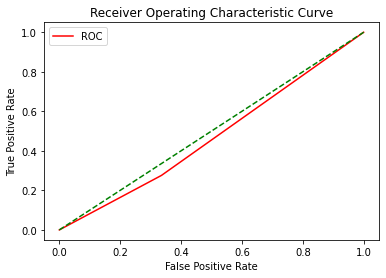

In [24]:
fper, tper, thresholds = roc_curve(ytest,ypred)
plot_roc_curve(fper, tper)

On peut voir que la courbe ROC est assez basse, pour que notre modèle soit optimale, il aurait fallut que la courbe passe par le point $(0,1)$. L'on voit donc que l'on peut encore améliorer notre modèle.

Le pourcentage de bonnes prédictions est de seulement $59\%$, cela veut dire qu'un peu plus de une prédiction sur deux est bonne, mais pas beaucoup plus. Ce qui laisse notre modèle assez peu précis et pas forcément très bon même voir pas du tout. 

Essayons d'autres classifieur.

## Classifieur : SVM

In [25]:
modelSVM = SVC()
modelSVM.fit(Xtrain,ytrain)

SVC()

In [26]:
ypredSVM = modelSVM.predict(Xtest)

In [27]:
MC1 = confusion_matrix(ytest, ypredSVM)
print("voici la matrice de confusion :")
print(MC1)
print("\n")
print("Nombre de résultats 0 que le modèle a prédit 0 : ", MC1[0][0])
print("Nombre de résultats 1 que le modèle a prédit 1 : ", MC1[1][1])
print("Nombre de résultats 1 que le modèle a prédit 0 : ", MC1[1][0])
print("Nombre de résultats 0 que le modèle a prédit 1 : ", MC1[0][1])
print("\n")
print("Pourcentage de bonnes prédictions : ", modelSVM.score(Xtest,ytest))
print("\n")
print(classification_report(ytest, ypredSVM))

voici la matrice de confusion :
[[137   0]
 [ 29   0]]


Nombre de résultats 0 que le modèle a prédit 0 :  137
Nombre de résultats 1 que le modèle a prédit 1 :  0
Nombre de résultats 1 que le modèle a prédit 0 :  29
Nombre de résultats 0 que le modèle a prédit 1 :  0


Pourcentage de bonnes prédictions :  0.8253012048192772


              precision    recall  f1-score   support

           0       0.83      1.00      0.90       137
           1       0.00      0.00      0.00        29

    accuracy                           0.83       166
   macro avg       0.41      0.50      0.45       166
weighted avg       0.68      0.83      0.75       166



La pourcentage de bonnes prédictions de ce modèle est de $82\%$. Ce qui le rend un peu plus précis (plus de $20\%$) que le modèle précédent.
Regardons quelle courbe ROC nous obtenons pour valider ou non notre modèle.

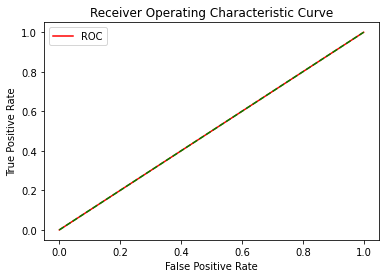

In [28]:
fper2, tper2, thresholds2 = roc_curve(ytest,ypredSVM)
plot_roc_curve(fper2, tper2)

L'on voit que la courbe ROC est inutile ici car l'air sous la courbe est de $50/50$, cela signifie qu'elle est non-significative. Autrement dit, elle ne pourra pas nous être utile pour notre dataset.

Essayons à nouveau avec un autre modèle.

## Classifieur : RANDOM FOREST

In [29]:
modelRF = RandomForestClassifier()
modelRF.fit(Xtrain,ytrain)

RandomForestClassifier()

In [30]:
ypredRF = modelRF.predict(Xtest)

In [31]:
MC2 = confusion_matrix(ytest, ypredRF)
print(MC2)
print("\n")
print("Nombre de résultats 0 que le modèle a prédit 0 : ", MC2[0][0])
print("Nombre de résultats 1 que le modèle a prédit 1 : ", MC2[1][1])
print("Nombre de résultats 1 que le modèle a prédit 0 : ", MC2[1][0])
print("Nombre de résultats 0 que le modèle a prédit 1 : ", MC2[0][1])
print("\n")
print("Pourcentage de bonnes prédictions : ", modelRF.score(Xtest,ytest))
print("\n")
print(classification_report(ytest, ypredRF))

[[133   4]
 [ 28   1]]


Nombre de résultats 0 que le modèle a prédit 0 :  133
Nombre de résultats 1 que le modèle a prédit 1 :  1
Nombre de résultats 1 que le modèle a prédit 0 :  28
Nombre de résultats 0 que le modèle a prédit 1 :  4


Pourcentage de bonnes prédictions :  0.8072289156626506


              precision    recall  f1-score   support

           0       0.83      0.97      0.89       137
           1       0.20      0.03      0.06        29

    accuracy                           0.81       166
   macro avg       0.51      0.50      0.48       166
weighted avg       0.72      0.81      0.75       166



Dans ce modèle si, nous avons un taux de prédictions un peu moins bon que le prédécent, ce qui nous laisse penser qu'il sera moins intéressant à utiliser. 
Regardons ce que la courbe ROC a à nous dire concernant ce modèle.

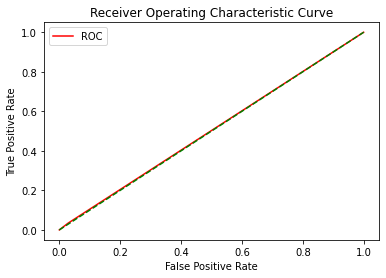

In [32]:
fper3, tper3, thresholds3 = roc_curve(ytest,ypredRF)
plot_roc_curve(fper3, tper3)

L'on voit que la courbe ROC est inutile ici car l'air sous la courbe est de $50/50$, celle ci est non-significatif.

Ce modèle ci n'est pas non plus approprié à notre model. 


Le modèle le plus approprié reste pour l'instant le model de Regression logistique, même si celui-ci reste pour l'instant moins précis qu'on le souhaiterait. Pour obtenir plus de précisions, nous pourrions ajouter d'autres paramètres tel que l'âge ou bien le sexe.